# RAG Workshop Notebook

**TDWI 2025 – Hands-on Session**

Dieses Notebook führt dich Schritt für Schritt durch den kompletten RAG-Workflow:

1. **Setup & Ziele** - Umgebung vorbereiten, Lernziele verstehen
# Index Pipeline
2. **🧹Daten laden & reinigen** – denn ohne Qualität läuft mal wieder nix
3. **✂️Chunking** – den Elefanten in Scheiben schneiden
4. **🧮Embedding** – die Welt in Vektoren gießen
# Vektorspeicher
5. **🗄️Vector Store** – Mathe statt Magie rund um FAISS, DuckDB, PostgreSQL
# RAG Pipeline
6. **🌀Prompt pimpen** – Quellen smart einbauen
7. **🪄Chat GPTiert** – Kontext drin, Halluzinationen draußen!?
8. **Evaluierung** - Ein paar einfache Checks


### Lernziele
Nach diesem Notebook kannst du …

1. die Kernidee hinter Retrieval‑Augmented Generation (RAG) erklären,
2. Beispiel-Webdaten laden und inspizieren,
3. Semantische Suche in Vektordatenbanken/indexes durchführen.

Du kannst das Notebook in Google Colab ausführen oder lokal auf deinem eigenen Notebook.
### Voraussetzungen
Voraussetzungen

Python-Kenntnisse
- Google Colab (frei verfügbare Notebook Umgebung https://colab.research.google.com/)
- HuggingFace-Account https://huggingface.co/ und LLM wie Gemini https://aistudio.google.com/apikey (jeweils ohne Kosten)
- Optional OpenAI-Account (API Guthaben notwendig, kostenpflichtig)

Zusätzliche Voraussetzungen bei lokaler Ausführung
- Python ≥ 3.12
- Falls PostgreSQL pgvector genutzt werden soll: lokale Docker/podman Installation

### Ablauf - grober Überblick
| Abschnitt | Zeit | Inhalt |
|-----------|------|--------|
| Setup (dieses Notebook) | 10 min | Umgebung, Datenquellen, Key-Handling |
| Daten laden | 10 min | Wiki Seite abrufen |
| Chunking | 15 min | Text in Häppchen |
| Embedding | 10 min | Vektorisierung & Kosten |
| Indexing | 15 min | Vektor-Datenbanken |
| Augmentation & Retrieval | 15 min | Daten anreichern und Chat |
| Evaluierung & Extras | 5 min | Metriken, RAG-Chains |

# 01 Setup
In diesem Abschnitt installieren wir Abhängigkeiten, importieren Libraries und definieren globale Konstanten.

### Schritt 01-01 – Python Pakete installieren
- In google colab requirements.txt zuerst nach content kopieren!
- Bei einem lokalen Notebook: requirements.txt liegt im Repository/Projekt-Rootverzeichnis, d.h. eine Ebene oberhalb von src/(dieses Notebook)

Der nachfolgende Installationsvorgang wird einige Minuten benötigen!

In [3]:
import sys
import subprocess
from pathlib import Path
import os, pathlib, sys

# prueft ob in Colab-Umgebung
is_colab  = "google.colab" in sys.modules
req_path  = Path("requirements.txt") if is_colab else Path("..") / "requirements.txt"
python_exe = sys.executable

# ist requirements.txt vorhanden?
if not req_path.exists():
    raise FileNotFoundError(
        f"Requirements-Datei nicht gefunden: {req_path.resolve()}\n"
        f"Aktueller Ordner des Kernels: {Path().resolve()}"
    )

subprocess.check_call(
    [python_exe, "-m", "pip", "install", "-r", str(req_path), "--no-cache-dir"]
)

print("Arbeitsverzeichnis:", os.getcwd())
print("Python-Version    :", sys.version.split()[0])
print("Inhalt:", list(pathlib.Path().iterdir())[:5])

Arbeitsverzeichnis: /content
Python-Version    : 3.11.13
Inhalt: [PosixPath('.config'), PosixPath('requirements.txt'), PosixPath('sample_data')]


### Schritt 01-02 – Import der Python Pakete und initiale Einstellungen
**LangChain** ist ein Open-Source-Framework, das Hilfsklassen und Bausteine bereitstellt, um Large-Language-Model-(LLM-)Anwendungen – vom einfachen Prompt-Template bis zum komplexen Retrieval-Augmented-Generation-(RAG-)Workflow – schnell zusammenzustecken.

Seit Ende 2024 wurden alle optionalen Integrationen (Loader, Embeddings, Tools u. a.) in das separate Paket **langchain-community** ausgelagert; das Kernpaket enthält nur noch die zentralen Abstraktionen, während langchain_community die Schnittstellen zu Dritt-Libs wie HuggingFace, OpenAI, Pinecone usw. bündelt.
Beide Pakete werden gemeinsam gepflegt und folgen demselben API-Stil.

**Vorteile**
* Sehr große Auswahl an fertigen Komponenten (Loader, Splitter, Embeddings, Vektordatenbanken).
* Einheitliche Schnittstellen erleichtern Rapid Prototyping und späteren Austausch einzelner Bausteine.
* Aktive Community, laufend neue Integrationen, gute Tutorials und Beispiele.

**Nachteile**
* Häufige Breaking Changes; Upgrade kann Code-Anpassungen erfordern.
* Viele optionale Abhängigkeiten → voluminöse Installation und längere Import-Zeit.
* Abstraktionslage kann Debugging erschweren, weil interne Aufrufe in mehreren Schichten verborgen sind.

In [48]:
import warnings
import textwrap
import copy
from langchain_community.document_loaders import AsyncHtmlLoader
from langchain_community.document_transformers import BeautifulSoupTransformer

from langchain.text_splitter import CharacterTextSplitter, RecursiveCharacterTextSplitter
from langchain_text_splitters import HTMLSectionSplitter

from langchain_huggingface import HuggingFaceEmbeddings
from langchain_openai import OpenAIEmbeddings

import google.generativeai as genai

import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS
from langchain_community.vectorstores.faiss import DistanceStrategy
from langchain_community.vectorstores import DuckDB
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import Runnable

from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import numpy as np
from textwrap import shorten
import duckdb, pandas as pd

# stellt den globalen Warnfilter so ein, dass keine Warnungen mehr angezeigt werden.
# Praktisch für saubere Demo-Notebooks, aber gefährlich,
# denn wichtige Infos können unterdrückt werden.
warnings.filterwarnings("ignore")

### Schritt 01-03 – Konfigurationen
Im Notebook wird nur eine Seite genutzt. Anhand dieser Seite werden die einzelnen Schritte gezeigt.

In [5]:
# Link zur Wikipedia-Seite, die verarbeitet wird
url = "https://en.wikipedia.org/wiki/Retrieval-augmented_generation"

# 02 🧹Daten laden & reinigen – denn ohne Qualität läuft mal wieder nix
In diesem Abschnitt laden wir die Wiki-Seite, zeigen die Metadaten und Nutzdaten an sowie entfernen html-Tags.

### Schritt 02-01 – Abrufen der Wiki-Seite
Die Wiki-Seite wird gelesen in die Variable html_page_ori. Diese Variable enthält
- Metadaten
- Nutzdaten ("Wikiseite") inklusive html-Tags.
Die Nutzdaten müssen im weiteren Verlauf bereinigt werden ("Cleansing").

In [7]:
# AsyncHtmlLoader (Langchain) lädt HTML-Seiten parallel ein und liefert sie als Document-Objekte zurück
HTMLloader = AsyncHtmlLoader (url)

html_page_ori = HTMLloader.load()

Fetching pages: 100%|##########| 1/1 [00:00<00:00, 15.47it/s]


### Schritt 02-02 – Metadaten prüfen/anzeigen

In [9]:
html_page = copy.deepcopy(html_page_ori)
print(html_page[0].metadata)

{'source': 'https://en.wikipedia.org/wiki/Retrieval-augmented_generation', 'title': 'Retrieval-augmented generation - Wikipedia', 'language': 'en'}


### Schritt 02-03 – Nutzdaten prüfen/anzeigen

In [10]:
# Es werden die ersten 1000 Zeichen angezeigt
# und mit Hilfe von textwrap "umgebrochen" statt einer langen Zeile
# html Tags sin noch enthalten
html_page = copy.deepcopy(html_page_ori)
content = html_page[0].page_content[:1000]
wrapped = textwrap.fill(content, width=80)

print(wrapped)

<!DOCTYPE html> <html class="client-nojs vector-feature-language-in-header-
enabled vector-feature-language-in-main-page-header-disabled vector-feature-
page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-
feature-main-menu-pinned-disabled vector-feature-limited-width-clientpref-1
vector-feature-limited-width-content-enabled vector-feature-custom-font-size-
clientpref-1 vector-feature-appearance-pinned-clientpref-1 vector-feature-night-
mode-enabled skin-theme-clientpref-day vector-sticky-header-enabled vector-toc-
available" lang="en" dir="ltr"> <head> <meta charset="UTF-8"> <title>Retrieval-
augmented generation - Wikipedia</title> <script>(function(){var
className="client-js vector-feature-language-in-header-enabled vector-feature-
language-in-main-page-header-disabled vector-feature-page-tools-pinned-disabled
vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled
vector-feature-limited-width-clientpref-1 vector-feature-limited-width-con

### Schritt 02-04 – Cleansing
Das Dokument beinhaltet html-Tags, die bereinigt werden müssen.
Dazu wird transform_documents aufgerufen. transform_documents ändert die Originaldaten, daher wird zuerst eine Kopie angelegt. Durch das Anlegen der Kopie können Zellen im Notebook mehrfach aufgerufen werden und ist somit fehlertoleranter (insb. transform_documents könnte sonst nur ein Mal aufgerufen werden oder es muss wieder von vorne begonnen werden und die Wiki-Seite muss abgerufen werden).

BeautifulSoupTransformer ist ein LangChain-Helper, der HTML-Dokumente mit Beautiful Soup parst und den Inhalt nach vorgegebenen Regeln ausdünnt.
Durch copy.deepcopy(html_page_ori) wird zuerst eine vollständige Kopie der geladenen Document-Liste erzeugt, damit das Original unverändert bleibt.
transform_documents(..., tags_to_extract=["p"]) entfernt anschließend alles außer den p-Tags: Jeder zurückgegebene Document enthält nur noch den reinen Paragraph-Text, Metadaten wie die URL bleiben erhalten.

In [11]:
soup_transformer = BeautifulSoupTransformer()

html_page = copy.deepcopy(html_page_ori)
html_page_transformed = soup_transformer.transform_documents(html_page, tags_to_extract=["p"])

### Schrittm 02-05 – Metadaten prüfen/anzeigen

In [12]:
print(html_page_transformed[0].metadata)

{'source': 'https://en.wikipedia.org/wiki/Retrieval-augmented_generation', 'title': 'Retrieval-augmented generation - Wikipedia', 'language': 'en'}


### Schritt 02-06 – Nutzdaten prüfen/anzeigen

In [15]:
content = html_page_transformed[0].page_content[:5000]
wrapped = textwrap.fill(content, width=80)

print(wrapped)

Retrieval-augmented generation ( RAG ) is a technique that enables large
language models (/wiki/Large_language_model) (LLMs) to retrieve and incorporate
new information. [ 1 (#cite_note-:1-1) ] With RAG, LLMs do not respond to user
queries until they refer to a specified set of documents. These documents
supplement information from the LLM's pre-existing training data
(/wiki/Training_data) . [ 2 (#cite_note-:2-2) ] This allows LLMs to use domain-
specific and/or updated information that is not available in the training data.
[ 2 (#cite_note-:2-2) ] [ 3 (#cite_note-:4-3) ] For example, this helps LLM-
based chatbots (/wiki/Chatbot) access internal company data or generate
responses based on authoritative sources. RAG improves large language models
(LLMs) by incorporating information retrieval (/wiki/Information_retrieval)
before generating responses. [ 4 (#cite_note-:5-4) ] Unlike traditional LLMs
that rely on static training data, RAG pulls relevant text from databases,
uploaded docume

# 03 ✂️Chunking – den Elefanten in Scheiben schneiden

### Theorie: Warum Chunking?
Large-Language-Modelle haben ein Kontextlimit (z.&nbsp;B. 128k Tokens bei GPT-4o). Ein langer Artikel muss daher in kleinere Teile („Chunks“) zerlegt werden. Die Wahl der Chunk-Größe und des Overlaps beeinflusst die Qualität der Ergebnisse.
Das Kontextlimit wird immer größer. Trotzdem ist ein Chunking sinnvoll, denn je größer der Text (Chunk) ist, umso mehr gehen relevante, spezifische Inhalte verloren.

Es gibt eine Vielzahl von Chunking-Möglichkeiten:
* **Fixed Length** (z.&nbsp;B. 1000 Zeichen) – simpel, aber ignoriert Satzgrenzen  
* **Token-basiert** – präziser, braucht `tiktoken`  
* **Rekursives Splitten** – behält semantische Einheiten (Absätze, Sätze)

### Schritt 03-01 – Anzahl Zeichen der Webseite

In [16]:
print(len(html_page_transformed[0].page_content))

11534


### Schritt 03-02 – Fixed Length Chunking
Einfaches Chunking anhand fixer Größen mit/ohne Überlappung von Zeichen.

Führe die Schritte 03-01 bis 03-03 mit verschiedenen Überlappungen aus (chunk_overlap=...), siehe 03-01.

In [18]:
text_splitter = CharacterTextSplitter(
separator=" ",               # Zeichen für das Trennen des Textes
chunk_size=1000,             # Anzahl Zeichen im Chunk
chunk_overlap=0,             # Anzahl überlappende Zeichen; wiederhole die nächsten Schritte mit anderen Werten, z.B. 0 oder 50
)

text_chunks=text_splitter.create_documents([html_page_transformed[0].page_content])

print(f"Anzahl Chunks, die erzeugt wurden: {len(text_chunks)}")

Anzahl Chunks, die erzeugt wurden: 12


### Schritt 03-03 – Chunks prüfen/anzeigen (1 von 2)
Es werden nun 2 Chunks miteinander verglichen.

In [21]:
# vergleiche die letzten Zeichen von Chunk 4 mit den ersten Zeichen von Chunk 5

content = text_chunks[1].page_content
wrapped = textwrap.fill(content, width=100)

print(wrapped)

documents, or web sources. [ 1 (#cite_note-:1-1) ] According to Ars Technica (/wiki/Ars_Technica) ,
"RAG is a way of improving LLM performance, in essence by blending the LLM process with a web search
or other document look-up process to help LLMs stick to the facts." This method helps reduce AI
hallucinations (/wiki/AI_hallucinations) , [ 4 (#cite_note-:5-4) ] [ 5 (#cite_note-:7-5) ] which
have caused chatbots to describe policies that don't exist, or recommend nonexistent legal cases to
lawyers that are looking for citations to support their arguments. [ 6 (#cite_note-:0-6) ] RAG also
reduces the need to retrain LLMs with new data, saving on computational and financial costs. [ 1
(#cite_note-:1-1) ] Beyond efficiency gains, RAG also allows LLMs to include sources in their
responses, so users can verify the cited sources. This provides greater transparency, as users can
cross-check retrieved content to ensure accuracy and relevance. The term RAG was first introduced in
a 2020 research

### Schritt 03-03 – Chunks prüfen/anzeigen (2 von 2)

In [22]:
content = text_chunks[2].page_content
wrapped = textwrap.fill(content, width=100)

print(wrapped)

paper [ 4 (#cite_note-:5-4) ] from Meta (/wiki/Meta_(Company)) . [ 7 (#cite_note-:6-7) ] [ 3
(#cite_note-:4-3) ] LLMs can provide incorrect information. For example, when Google first
demonstrated its LLM tool " Google Bard (/wiki/Google_Bard) ", the LLM provided incorrect
information about the James Webb Space Telescope (/wiki/James_Webb_Space_Telescope) . This error
contributed to a $100 billion decline in the company (/wiki/Alphabet_Inc.) ’s stock value. [ 6
(#cite_note-:0-6) ] RAG is used to prevent these errors, but it does not solve all the problems. For
example, LLMs can generate misinformation even when pulling from factually correct sources if they
misinterpret the context. [ 8 (#cite_note-:8-8) ] MIT Technology Review
(/wiki/MIT_Technology_Review) gives the example of an AI-generated response stating, "The United
States has had one Muslim president, Barack Hussein Obama." The model retrieved this from an
academic book rhetorically titled Barack Hussein Obama: America’s First


### Schritt 03-04 - Verteilung der Anzahl Zeichen von Minimum bis Maximum

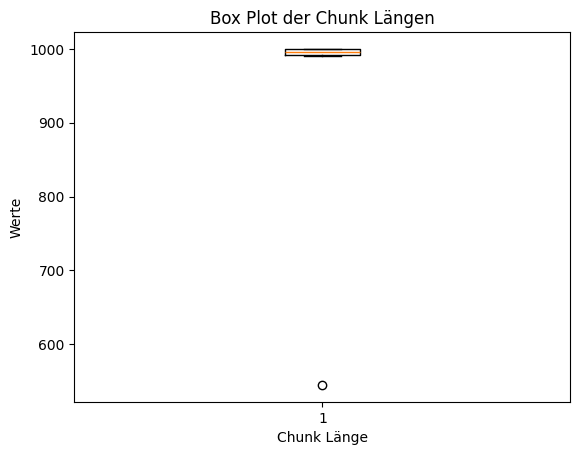

Median Chunk Länge: 996.0
Durchschnittliche Chunk Länge: 958.58
Minimum Chunk Länge: 545
Max Chunk Länge: 1000


In [23]:
data = [len(doc.page_content) for doc in text_chunks]

plt.boxplot(data)
plt.title('Box Plot der Chunk Längen')
plt.xlabel('Chunk Länge')
plt.ylabel('Werte')

plt.show()

print(f"Median Chunk Länge: {round(np.median(data),2)}")
print(f"Durchschnittliche Chunk Länge: {round(np.mean(data),2)}")
print(f"Minimum Chunk Länge: {round(np.min(data),2)}")
print(f"Max Chunk Länge: {round(np.max(data),2)}")

### Schritt 03-05 – Rekursives Splitten
Verbessertes Chunking anhand thematischer Einheiten, z.B. Überschriften oder Tabellen in einer html-Seite.

sections_to_split_on legt fest, an welchen HTML-Elementen der Text zerlegt werden soll: Immer wenn im Quell-HTML ein h1, h2, h3 oder table auftaucht, beginnt der HTMLSectionSplitter einen neuen Abschnitt.

Mit HTMLSectionSplitter(sections_to_split_on) erstellst du daher einen Chunker, der strukturbewusst entlang dieser Tags splittet, statt einfach blind nach Zeichenlänge.

copy.deepcopy(html_page_ori) schützt das Original vor Veränderungen, anschließend wird in split_text(html_page[0].page_content) nur der kopierte HTML-String verarbeitet.

Das Ergebnis split_content ist eine Liste von Textsegmenten, die jeweils genau den Inhalt eines Headers bzw. einer Tabelle (plus folgenden Fließtext bis zum nächsten Split-Tag) enthalten – optimal für ein verbessertes Chunking vor dem Embedding.

Führe die nachfolgenden Schritte durch und vergleiche die Ergebnisse wenn ("p","P") auskommentiert ist oder nicht.

In [25]:
sections_to_split_on = [
     ("h1", "Header 1"),
     ("h2", "Header 2"),
     ("h3", "Header 3"),
     ("table","Table"),
     #("div", "Div"),
     #("img","Image"),
     #("p","P"),
]

splitter = HTMLSectionSplitter(sections_to_split_on)

html_page = copy.deepcopy(html_page_ori)
split_content = splitter.split_text(html_page[0].page_content)

### Schritt 03-06 - Anzahl Chunks prüfen/anzeigen

In [26]:
len(split_content)

22

### Schritt 03-07 - die ersten 5 Chunks prüfen/anzeigen

In [33]:
#split_content[:5]
for i, doc in enumerate(split_content[:5], 1):
   header = next(iter(doc.metadata.values()), "–")
   preview = shorten(doc.page_content.replace("\n", " "), 120)
   print(f"{i:02d}. {header}: {preview}")


01. #TITLE#: Jump to content Main menu Main menu move to sidebar hide Navigation Main page Contents Current events Random [...]
02. Contents: Contents move to sidebar hide (Top) 1 RAG and LLM Limitations 2 Process Toggle Process subsection 2.1 RAG key [...]
03. Retrieval-augmented generation: Retrieval-augmented generation 12 languages Català Čeština Deutsch Français 한국어 Italiano Polski Русский Ślůnski [...]
04. RAG and LLM Limitations: RAG and LLM Limitations [ edit ] LLMs can provide incorrect information. For example, when Google first [...]
05. Process: Process [ edit ] Retrieval-Augmented Generation (RAG) enhances large language models (LLMs) by incorporating an [...]


### Schritt 03-08 – Chunks per Abschnitt prüfen/anzeigen
Abschnitte sind z.B. Überschriften 1., 2., 3. Ebene, Tabellen oder andere html-Abschnitte. Wie viele Chunks je Abschnitt sind vorhanden?

In [ ]:
from collections import Counter

class_counter = Counter()

for doc in split_content:
    document_class = next(iter(doc.metadata.keys()))
    class_counter[document_class] += 1

print(class_counter)

Counter({'Header 3': 8, 'Header 2': 6, 'Table': 6, 'Header 1': 2})


### Schritt 03-09 - Verteilung der Anzahl Zeichen von Minimum bis Maximum

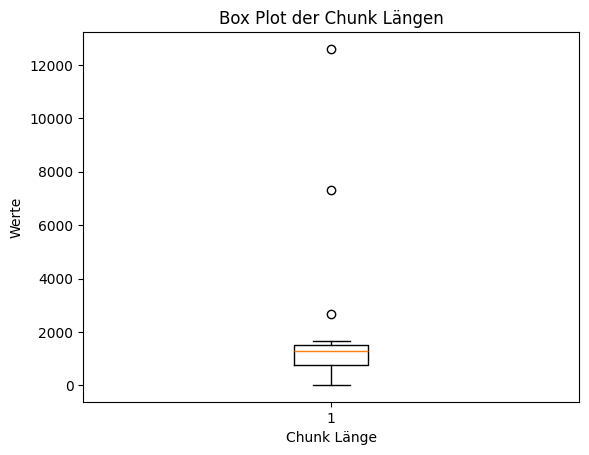

Median Chunk Länge: 1273.0
Durchschnittliche Chunk Länge: 1918.68
Minimum Chunk Länge: 19
Max Chunk Länge: 12595


In [34]:
data = [len(doc.page_content) for doc in split_content]

plt.boxplot(data)
plt.title('Box Plot der Chunk Längen')
plt.xlabel('Chunk Länge')
plt.ylabel('Werte')

plt.show()

print(f"Median Chunk Länge: {round(np.median(data),2)}")
print(f"Durchschnittliche Chunk Länge: {round(np.mean(data),2)}")
print(f"Minimum Chunk Länge: {round(np.min(data),2)}")
print(f"Max Chunk Länge: {round(np.max(data),2)}")

### Schritt 03-10 - Verteilung der Anzahl Zeichen ändern
In der nächsten Zelle werden die Anzahl Zeichen limitiert, so dass die Ungleichverteilung reduziert wird.

In [37]:
# Obergrenze von chunk_size= Zeichen innerhalb eines Chunks
text_splitter = RecursiveCharacterTextSplitter(
separators=[" ","\n","."],   # Zeichen für das Trennen des Textes
chunk_size=5000,             # Anzahl Zeichen im Chunk
chunk_overlap=50,            # Anzahl überlappende Zeichen; wiederhole die nächsten Schritte mit anderen Werten, z.B. 0 oder 50
)

final_chunks=text_splitter.split_documents(split_content)

print(f"Anzahl Chunks, die erzeugt wurden: {len(final_chunks)}")

Anzahl Chunks, die erzeugt wurden: 25


### Schritt 03-11 - Verteilung der Anzahl Zeichen von Minimum bis Maximum

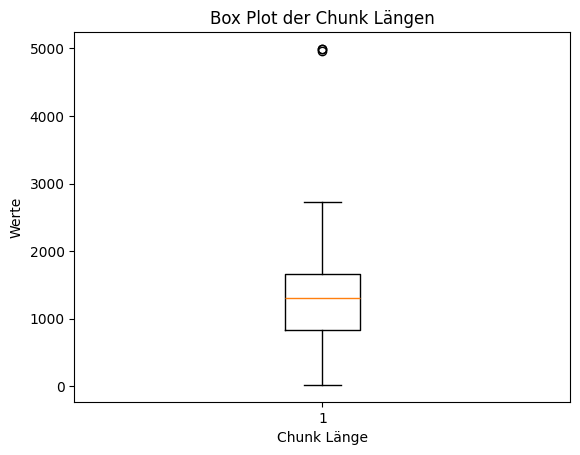

Median Chunk Länge: 1302.0
Durchschnittliche Chunk Länge: 1693.56
Minimum Chunk Länge: 19
Max Chunk Länge: 4993


In [38]:
data = [len(doc.page_content) for doc in final_chunks]

plt.boxplot(data)
plt.title('Box Plot der Chunk Längen')
plt.xlabel('Chunk Länge')
plt.ylabel('Werte')

plt.show()

print(f"Median Chunk Länge: {round(np.median(data),2)}")
print(f"Durchschnittliche Chunk Länge: {round(np.mean(data),2)}")
print(f"Minimum Chunk Länge: {round(np.min(data),2)}")
print(f"Max Chunk Länge: {round(np.max(data),2)}")

# 04 🧮Embedding – die Welt in Vektoren gießen

### Schritt 04-01 – API Keys einlesen
Die API Keys in Google Colab in Secrets hinzufügen oder bei einem lokalen Notebook in die Datei .env

Der OpenAI Key ist optional (zumindest einen dummy Wert setzen). Die API Keys für Huggingface und Gemini sind frei (ohne Kosten). Die Keys haben die folgenden Namen:
* OPENAI_API_KEY
* HF
* GEMINI

Für OpenAI: Einen API Key unter https://platform.openai.com/settings/organization/api-keys erzeugen. Achtung: der Zugriff erzeugt Kosten. Ein ChatGPT Abo reicht nicht, es muss ein API-Guthaben vorhanden sein.

Gür GEMINI: Einen API Key unter https://aistudio.google.com/apikey erzeugen.

In [42]:
if is_colab:
  from google.colab import userdata
  api_key_openai = userdata.get('OPENAI_API_KEY')
  api_key_hf = userdata.get("HF")
  api_key_gemini = userdata.get("GEMINI")
else:
  from pathlib import Path
  from dotenv import load_dotenv, find_dotenv
  import os
  load_dotenv(find_dotenv())
  api_key_openai = os.getenv("OPENAI_API_KEY")
  api_key_hf = os.getenv("HF")
  api_key_gemini = os.getenv("GEMINI")

### Schritt 04-02 – Open Source Embedding Modell Hugging Face
logout() entfernt eventuell veraltete Hugging-Face-Tokens aus der lokalen Cache-Datei, damit nach einem fehlgeschlagenen Auth-Versuch keine 401-Fehler mehr auftreten.

login(api_key_hf) hinterlegt anschließend deinen aktuellen API-Key, sodass der Transformer-Checkpoint später automatisch aus dem Hub geladen werden kann.

Mit HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2") erstellst du einen LangChain-Wrapper, der das Sentence-Transformer-Modell all-mpnet-base-v2 intern als Encoder nutzt.

embed_documents([...]) feuert den Encoder auf jede Text-Chunk-Zeile aus final_chunks und liefert für jeden Chunk einen hochdimensionalen Vektor zurück – die Basis für semantische Suche oder Retrieval-Augmented-Generation.

Der nachfolgende Codeabschnitt kann einige Minuten dauern und mit einer Warnung beginnen: Not logged in!
WARNING:huggingface_hub._login:Not logged in!

In [43]:
from huggingface_hub import logout, login
logout()
login(api_key_hf)

embeddings_os = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-mpnet-base-v2"
)

hf_embeddings_os = embeddings_os.embed_documents([chunk.page_content for chunk in final_chunks])

Not logged in!


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### Schritt 04-03 - Embeddings prüfen/anzeigen

In [44]:
print(f"Länge des Embedding Vektors ist {len(hf_embeddings_os[0])}")
print(f"Das Embedding Objekt ist ein Array mit Anzahl Zeilen (Anzahl Chunks) X Vektorlänge {len(hf_embeddings_os)} X {len(hf_embeddings_os[0])}")

Länge des Embedding Vektors ist 768
Das Embedding Objekt ist ein Array mit Anzahl Zeilen (Anzahl Chunks) X Vektorlänge 25 X 768


### Schritt 04-04 – OpenAI Embedding Modell
Optionaler Schritt: zum Vergleich werden Embeddings mit OpenAI erzeugt.

In [45]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small",
                              openai_api_key=api_key_openai )

openai_embeddings = embeddings.embed_documents([chunk.page_content for chunk in final_chunks])


### Schritt 04-05 - Embeddings prüfen/anzeigen
Optionaler Schritt für OpenAI.



In [47]:
print(f"Länge des Embedding Vektors ist {len(openai_embeddings[0])}")
print(f"Das Embedding Objekt ist ein Array mit Anzahl Zeilen (Anzahl Chunks) X Vektorlänge {len(openai_embeddings)} X {len(openai_embeddings[0])}")

Länge des Embedding Vektors ist 1536
Das Embedding Objekt ist ein Array mit Anzahl Zeilen (Anzahl Chunks) X Vektorlänge 25 X 1536


# 05 🗄️Vector Store – Mathe statt Magie rund um FAISS, DuckDB, PostgreSQL
Speicherung der Vektoren in einer Datenbank (z.B. PostgreSQL pgvector, Qdrant, Chroma, Milvus, Oracle, etc) oder einem Vektroindex (z.B. FAISS "Facebook AI Similarity Search").
Eine Datenbank kann neben den Vektoren auch die Nutzdaten speichern

### Schritt 05-01 FAISS konfigurieren und Vektoren erzeugen
faiss.IndexFlatIP(...) erzeugt zunächst einen flachen FAISS-Index, der rein das Skalarprodukt auswertet; die Vektordimension wird aus dem ersten Embedding abgeleitet.

Der LangChain-Wrapper FAISS(...) verbindet diesen Index mit der Embedder-Funktion (embeddings_os), einem kleinen In-Memory-Docstore und einem leeren Mapping index_to_docstore_id, sodass jede gespeicherte Vektorposition wieder auf ihr Ursprungs-Document zurückgeführt werden kann.

Mit distance_strategy=DistanceStrategy.COSINE teilt man LangChain mit, die Ähnlichkeit als Kosinus zu interpretieren – dafür sollten die Dokument-Vektoren vor dem Einfügen (automatisch oder manuell) auf Einheitslänge normiert werden, weil IndexFlatIP selbst nur das Dot-Product speichert.

add_documents(final_chunks) lässt LangChain jeden Chunk einbetten, optional normalisieren und anschließend sowohl im FAISS-Index als auch im Docstore ablegen; damit ist der semantische Suchraum für spätere Queries vollständig eingerichtet.

**Warum Docstore?**
Für den reinen FAISS-Algorithmus brauchst du nur den Index – dort liegen die Vektor­koordinaten.
Der docstore ist lediglich eine Komfortschicht von LangChain: Er merkt sich, welches Document (inkl. Metadata) zu welcher Index-Position gehört. Methoden wie similarity_search() oder as_retriever() holen darüber automatisch den Originaltext zurück.
Verzichtest du auf den Docstore, musst du nach einer Vektorabfrage die Treffer-IDs selbst in ein externes Mapping auf deine Dokumente auflösen – oder gleich ganz ohne LangChain-Wrapper direkt mit FAISS arbeiten.

**Warum normalize=tru?** wenn doch Cosinus ohne Normierung funktioniert? FAISS-Index IndexFlatIP kennt aber nur das reine Skalarprodukt (inner product) und berechnet beim Suchen keinerlei Normen. Damit sein Ergebnis dennoch exakt dem Cosinus entspricht, müssen alle Vektoren schon beim Einfügen auf Einheitslänge normalisiert werden


In [52]:
index = faiss.IndexFlatIP(len(hf_embeddings_os[0]))

vector_store = FAISS(
    embedding_function = embeddings_os,
    index               = index,
    docstore            = InMemoryDocstore(),
    index_to_docstore_id= {},
    normalize_L2=True,
    distance_strategy   = DistanceStrategy.COSINE
)

vector_store.add_documents(final_chunks)

['7889273b-7793-43b5-af82-5e05cb90d105',
 '73915ec8-2db4-47ef-af69-e6d3b62367f1',
 '9df5f63c-0280-4f31-b121-e16a844831e2',
 '00b14be4-1b2a-423c-bd8b-b347aca6c64a',
 'ae3986a7-0172-421f-b394-84991c0a33a4',
 'b383f130-565f-4a03-b00b-aafed951bd0a',
 '07aae5dc-b67e-46be-bad5-7f7fd2bd0d19',
 'c6ad6417-4e54-47bb-bcb2-0a9d952464bb',
 '1a23abb4-d96e-4792-8f12-fe4d313f257a',
 '7ad67e5d-d51f-4649-b018-aeb80f4bd288',
 '008b08db-a9b1-4bcd-a288-e3ec6f776a95',
 '87b3ac83-e803-407f-8eed-5f74ba57ea2b',
 '3d23ad44-f756-4495-aa4e-749000c3a36f',
 'f7096653-0ca0-40bc-95be-65d4eb339021',
 '7330014e-9c98-42ec-8b1c-ff71968e1d7b',
 '2e603e19-5971-4e72-97f4-1b30ddecf654',
 '99fdf03b-e534-4e3b-90ed-98c98ddd321b',
 '11f09e49-20ea-4e42-91ea-baf4df685850',
 'd4e9b6fe-8b9e-4c34-bfa6-ddba7bfb7148',
 'b5ffcb19-3e10-4702-9128-9f472e16ecec',
 '5e528909-42f6-4614-a3e5-691e4032ff19',
 'f502d886-7f42-4712-8cf2-d5ba5c22a147',
 '8af34475-c277-4ad2-8be2-dac223be049c',
 '0990b1f8-40c3-4613-b70e-38d92f2d8357',
 '34f706d8-5cf2-

### Schritt 05-02 - FAISS Index speichern
Der eingebaute InMemoryDocstore lebt nur so lange wie der Python-Prozess; speicherst du lediglich den Roh-Index mit faiss.write_index, überdauern nur die Vektor­daten – die Texte sind danach weg.
Nutzt du dagegen den LangChain-Wrapper und rufst vector_store.save_local("pfad") auf, legt er zwei Dateien an: index.faiss für die Vektoren und docstore.pkl für Docs & Mapping. Beim nächsten Start kannst du alles mit FAISS.load_local("pfad", embeddings) vollständig wiederherstellen, inklusive Docstore.

In [54]:
vector_store.save_local(folder_path="Data",index_name="Wiki_index")

### Schritt 05-03 - Ähnlichkeitssuche im FAISS Index
In der Vektordatenbank/Vektorindex wird eine Ähnlichkeitssuche durchgeführt und das ähnlichste Dokument wird angezeigt.

In [53]:
query = "What are key stages?"

docs = vector_store.similarity_search(query)

print(docs[0].page_content)

RAG key stages 
 [ edit ] 
 
 
 Indexing 
 [ edit ] 
 
 Typically, the data to be referenced is converted into LLM  embeddings , numerical representations in the form of a large vector space. [ 8 ]  RAG can be used on unstructured (usually text), semi-structured, or structured data (for example  knowledge graphs ). [ 12 ]  These embeddings are then stored in a  vector database  to allow for  document retrieval . [ 13 ] 
 
 Overview of RAG process, combining external documents and user input into an LLM prompt to get tailored output 
 
 Retrieval 
 [ edit ] 
 
 Given a user query, a document retriever is first called to select the most relevant documents that will be used to augment the query. [ 2 ] [ 4 ]  This comparison can be done using a variety of methods, which depend in part on the type of indexing used. [ 1 ] [ 12 ] 
 
 
 Augmentation 
 [ edit ] 
 
 The model feeds this relevant retrieved information into the LLM via  prompt engineering  of the user's original query. [ 10 ] [ 14

### Schritt 05-04 DuckDB konfigurieren und Vektoren erzeugen
DuckDB ist eine spaltenorientierte, in-process OLAP-Datenbank („SQLite für Analytics“). Sie läuft ohne Server, liest direkt Parquet/CSV/JSON, beschleunigt größere Abfragen dank Vektor-Ausführung und lässt sich nahtlos in Python, R oder C++ einbetten – ideal, wenn man analytische SQL-Power in einem einzigen Datei-Container benötigt.

Der Code baut einen Vektor-Store auf DuckDB-Basis:
* DuckDB.from_documents(...) bettet jeden Chunk mit embeddings_os ein und legt die resultierenden Vektoren samt Original-Text in einer neuen DuckDB-Tabelle ab.
* connection sorgt dafür, dass alles sofort in eine Datei geschrieben wird und nach Kernel-Neustarts weiterverwendbar ist.

In [75]:
conn = duckdb.connect("Data/duckdb_vectors.duckdb")

vector_store_duckDB = DuckDB.from_documents(
    documents = final_chunks,
    embedding = embeddings_os,
    connection = conn,
)

conn.close()

### Schritt 05-05 Tabelle in DuckDB anzeigen

Die Nutzdaten (Texte + Metadaten) wandern zusammen mit den Vektoren in dieselbe .duckdb-Datei.
LangChain legt dort intern eine Tabelle embeddings für Metadaten und Nutzdaten an. Diese wird nun mittels SQL abgefragt.

In [78]:
con = duckdb.connect("Data/duckdb_vectors.duckdb")

# Schema inspizieren
print(con.execute("DESCRIBE embeddings").fetchdf())

# Erste Einträge ansehen
df = con.execute("""
    SELECT id,
           left(text, 60)   AS preview,
           embedding,
           metadata
    FROM embeddings
    LIMIT 3
""").fetchdf()

display(df)
con.close()


  column_name column_type null   key default extra
0          id     VARCHAR   NO   PRI    None  None
1        text     VARCHAR  YES  None    None  None
2   embedding     FLOAT[]  YES  None    None  None
3    metadata     VARCHAR  YES  None    None  None


,id,preview,embedding,metadata
0,75e6ce45-09be-49b7-a464-84de3cc268da,Jump to content \n \n \n \n \n \n \n \n Main m...,"[0.02118021, -0.06125822, -0.022656694, 0.0098...","{""Header 1"": ""#TITLE#""}"
1,f4dbbc3c-eaf5-421b-bbf4-438be0a21b3a,Contents \n move to sidebar \n hide \n \n \n \...,"[0.060398534, 0.011601106, -0.029227823, 0.037...","{""Header 2"": ""Contents""}"
2,8fc5cd84-34fd-4bcb-a66e-fee26858d79b,Retrieval-augmented generation \n \n \n \n 12 ...,"[0.071465515, -0.0012724106, -0.043260608, -0....","{""Header 1"": ""Retrieval-augmented generation""}"


### Schritt 05-06 - Ähnlichkeitssuche in DuckDB
Der Code umgeht die fehlende similarity_search_with_relevance_scores()-Methode des DuckDB-Vector-Stores, indem er die Relevanzwerte nachträglich selbst ausrechnet.
* Zuerst wird der Abfrage­text mit embeddings_os.embed_query() in einen Vektor übersetzt (query_embedding).
* vector_store_duckDB.similarity_search(query, k=3) liefert die drei textlich ähnlichsten Chunks, aber ohne Score.
* Für jeden Treffer wird erneut ein Embedding erzeugt (doc_embedding) und per cosine_similarity() aus scikit-learn der Kosinus-Wert zwischen Query- und Dokumentvektor berechnet.
* Die Schleife druckt schließlich pro Ergebnis den berechneten Ähnlichkeitswert sowie den zugehörigen Inhalt.
Damit erhältst du nachträglich verlässliche Relevanz-Scores, zahlst aber den Preis, die Dokument-Vektoren ein zweites Mal zu berechnen.

In [82]:
conn = duckdb.connect("Data/duckdb_vectors.duckdb")
vector_store_duckDB = DuckDB(connection=conn,
                             embedding=embeddings_os)
# Embedding erstellen
query_embedding = embeddings_os.embed_query(query)

# top-k Dokumente/Chunks abrufen
docs = vector_store_duckDB.similarity_search(query, k=3)

# Ähnlichkeitsmaß manuell berechnen
for i, doc in enumerate(docs):
    doc_embedding = embeddings_os.embed_query(doc.page_content)
    similarity = cosine_similarity(
        np.array(query_embedding).reshape(1, -1),
        np.array(doc_embedding).reshape(1, -1)
    )[0][0]

    print(f"\nErgebnis #{i+1}")
    print(f"Ähnlichkeit (similarity): {similarity:.4f}")
    print(f"Inhalt:\n{doc.page_content}")

con.close()


Ergebnis #1
Ähnlichkeit (similarity): 0.2145
Inhalt:
RAG key stages 
 [ edit ] 
 
 
 Indexing 
 [ edit ] 
 
 Typically, the data to be referenced is converted into LLM  embeddings , numerical representations in the form of a large vector space. [ 8 ]  RAG can be used on unstructured (usually text), semi-structured, or structured data (for example  knowledge graphs ). [ 12 ]  These embeddings are then stored in a  vector database  to allow for  document retrieval . [ 13 ] 
 
 Overview of RAG process, combining external documents and user input into an LLM prompt to get tailored output 
 
 Retrieval 
 [ edit ] 
 
 Given a user query, a document retriever is first called to select the most relevant documents that will be used to augment the query. [ 2 ] [ 4 ]  This comparison can be done using a variety of methods, which depend in part on the type of indexing used. [ 1 ] [ 12 ] 
 
 
 Augmentation 
 [ edit ] 
 
 The model feeds this relevant retrieved information into the LLM via  prompt 

# 06 🌀Prompt pimpen – Quellen smart einbauen
Der Prompt wird angereichert mit dem Inhalt der Ähnlichkeitssuche.

### Schritt 06-01 - Daten für Prompt abfragen (aus Vektorfdatenbank/index holen)

In [83]:
# Abfrage definieren
query = "What are key stages?"

# Ähnlichkeitssuche durchführen
retrieved_docs = vector_store_duckDB.similarity_search(query, k=2)  # Top-2 Chunks erhalten

# Ergebnisse anzeigen

import textwrap

for i, doc in enumerate(retrieved_docs):
    print(textwrap.fill(f"\nRetrieved Chunk {i+1}:\n{doc.page_content}",width=100))
    print("\n\n")

 Retrieved Chunk 1: RAG key stages   [ edit ]       Indexing   [ edit ]     Typically, the data to
be referenced is converted into LLM  embeddings , numerical representations in the form of a large
vector space. [ 8 ]  RAG can be used on unstructured (usually text), semi-structured, or structured
data (for example  knowledge graphs ). [ 12 ]  These embeddings are then stored in a  vector
database  to allow for  document retrieval . [ 13 ]     Overview of RAG process, combining external
documents and user input into an LLM prompt to get tailored output     Retrieval   [ edit ]
Given a user query, a document retriever is first called to select the most relevant documents that
will be used to augment the query. [ 2 ] [ 4 ]  This comparison can be done using a variety of
methods, which depend in part on the type of indexing used. [ 1 ] [ 12 ]       Augmentation   [ edit
]     The model feeds this relevant retrieved information into the LLM via  prompt engineering  of
the user's original qu

### Schritt 06-02 Prompt erstellen
Der Code fasst zunächst den Inhalt der beiden relevantesten Dokument-Chunks (retrieved_docs[0] und [1]) zu einem einzigen retrieved_context-String zusammen. Anschließend wird daraus ein augmented_prompt gebaut, der dem LLM klar vorgibt, nur auf Basis dieses Kontexts die gestellte Frage (query) zu beantworten und bei fehlender Information ehrlich mit „I don’t know“ zu reagieren. Mit textwrap.fill wird der Prompt schließlich formatiert, damit er beim Ausdrucken im Notebook leserlich umbricht.

In [84]:
# Die ersten beiden Dokumente werden verwendet
retrieved_context=retrieved_docs[0].page_content + retrieved_docs[1].page_content

# Prompt zusammenstellen
augmented_prompt=f"""

Given the context below answer the question.

Question: {query}

Context : {retrieved_context}

Remember to answer only based on the context provided and not from any other source.

If the question cannot be answered based on the provided context, say I don’t know.

"""

print(textwrap.fill(augmented_prompt,width=150))

  Given the context below answer the question.  Question: What are key stages?  Context : RAG key stages   [ edit ]       Indexing   [ edit ]
Typically, the data to be referenced is converted into LLM  embeddings , numerical representations in the form of a large vector space. [ 8 ]  RAG can
be used on unstructured (usually text), semi-structured, or structured data (for example  knowledge graphs ). [ 12 ]  These embeddings are then stored
in a  vector database  to allow for  document retrieval . [ 13 ]     Overview of RAG process, combining external documents and user input into an LLM
prompt to get tailored output     Retrieval   [ edit ]     Given a user query, a document retriever is first called to select the most relevant
documents that will be used to augment the query. [ 2 ] [ 4 ]  This comparison can be done using a variety of methods, which depend in part on the
type of indexing used. [ 1 ] [ 12 ]       Augmentation   [ edit ]     The model feeds this relevant retrieved infor

# 07 🪄Chat GPTiert – Kontext drin, Halluzinationen draußen!?
Der Prompt ist erstellt und die Anfrage kann nun an das LLM gesendet werden.

### Schritt 07-01 - Prompt an öffentliche gehostetes GEMINI Modell senden und Antwort anzeigen
genai.configure(api_key=…) legt den Google-API-Key fest, damit nachfolgende Aufrufe authentifiziert sind.
GenerativeModel("gemini-1.5-flash") instanziiert die schnelle Gemini-1.5-Flash-Variante.
Die Klasse GeminiRunnable verpackt das Modell in ein LangChain-kompatibles Runnable: invoke() wandelt jeden Input in einen String, ruft model.generate_content(prompt) auf und gibt nur den reinen Antwort­text zurück.
Mit gemini_llm.invoke(augmented_prompt) wird genau dieser Ablauf ausgeführt und die Antwort für das zuvor gebaute Retrieval-Prompt ausgegeben.

In [85]:
genai.configure(api_key=api_key_gemini)

model = genai.GenerativeModel("gemini-1.5-flash")

class GeminiRunnable(Runnable):
    def invoke(self, input, config=None):
        prompt = input.to_string() if hasattr(input, "to_string") else str(input)
        response = model.generate_content(prompt)
        return response.text

gemini_llm = GeminiRunnable()

response_gemini = gemini_llm.invoke(augmented_prompt)
print(response_gemini)

Based on the provided text, the key stages of RAG are:  Indexing, Retrieval, Augmentation, and Generation.



### Schritt 07-02 - Prompt an OpenAI senden und Antwort anzeigen
ChatOpenAI legt eine Chat-Schnittstelle zu OpenAI fest; hier wird das kompakte Modell „gpt-4o-mini“ genutzt und mit temperature=0 deterministisch gemacht.
Mit max_tokens=None übernimmt die API ihr Standardlimit, timeout=None wartet unbegrenzt, und max_retries=2 erlaubt zwei automatische Wiederholungen bei Netz-/Rate-Limit-Fehlern.
messages enthält genau eine Rolle-Inhalts-Kombination – der Retrieval-Prompt steht als „human“-Nachricht darin – und wird via llm.invoke(messages) an das Modell geschickt.
Die Methode liefert ein AIMessage-Objekt zurück (ai_msg), dessen .content den finalen Antworttext des LLM enthält.

In [86]:
from langchain_openai import ChatOpenAI

# LLM Anfrage konfigurieren
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    openai_api_key=api_key_openai
)

messages=[("human",augmented_prompt)]

ai_msg = llm.invoke(messages)



# Antwort aus dem Response-Objekt extrahieren
response_openai=ai_msg.content

print(response_openai)

The key stages in the RAG (Retrieval-Augmented Generation) process are:

1. **Indexing**: Data is converted into LLM embeddings and stored in a vector database for document retrieval.
2. **Retrieval**: A document retriever selects the most relevant documents based on a user query.
3. **Augmentation**: Relevant retrieved information is fed into the LLM through prompt engineering of the user's query.
4. **Generation**: The LLM generates output based on the query and the retrieved documents, potentially incorporating additional steps for improving the output.


# 08 Evaluierung - Ein paar einfache Checks

### Schritt 08-01 Einfache Evaluierung (1)
Evaluierung durch Vergleich von erwarteten Schlüsselwörtern in der Antwort.
Vergleich mit Antwort von GEMINI.

In [87]:
ground_truth = {
    "What are key stages?": ["Indexing", "Vector", "Retrieval", "Augmentation", "Generation"],
}


treffer = sum([1 for wort in ground_truth["What are key stages?"] if wort.lower() in response_gemini.lower()])
print(f"Antwort: {response_gemini}\nTreffer: {treffer}/{len(ground_truth['What are key stages?'])}")


Antwort: Based on the provided text, the key stages of RAG are:  Indexing, Retrieval, Augmentation, and Generation.

Treffer: 4/5


### Schritt 08-02 Einfache Evaluierung (2)
Evaluierung durch Vergleich von erwarteten Schlüsselwörtern in der Antwort.
Vergleich mit Antwort von OpenAI.

In [88]:
ground_truth = {
    "What are key stages?": ["Indexing", "Vector", "Retrieval", "Augmentation", "Generation"],
}


treffer = sum([1 for wort in ground_truth["What are key stages?"] if wort.lower() in response_openai.lower()])
print(f"Antwort: {response_openai}\nTreffer: {treffer}/{len(ground_truth['What are key stages?'])}")

Antwort: The key stages in the RAG (Retrieval-Augmented Generation) process are:

1. **Indexing**: Data is converted into LLM embeddings and stored in a vector database for document retrieval.
2. **Retrieval**: A document retriever selects the most relevant documents based on a user query.
3. **Augmentation**: Relevant retrieved information is fed into the LLM through prompt engineering of the user's query.
4. **Generation**: The LLM generates output based on the query and the retrieved documents, potentially incorporating additional steps for improving the output.
Treffer: 5/5


### Schritt 08-03 Evaluierung durch LLM (1)
Evaluierung der Antwort von Gemini durch OpenAI LLM
*   correctness: Ist die Antwort sachlich korrekt?
*   conciseness: Ist sie knapp & auf den Punkt?
*   relevance: Beantwortet sie die Frage?
*   coherence: Klingt sie flüssig & verständlich?

In [89]:
from langchain.evaluation import load_evaluator
from langchain_openai import ChatOpenAI

# correctness, relevance, conciseness, coherence
evaluator = load_evaluator("labeled_criteria", criteria="correctness", llm=ChatOpenAI(openai_api_key=api_key_openai))

ergebnis = evaluator.evaluate_strings(
    input="What are key stages?",
    prediction=response_gemini,
    reference="Indexing, Vector, Retrieval, Augmentation, Generation"
)
print(ergebnis["score"], ergebnis["reasoning"])


0 Step by step reasoning:
1. The submission lists "Indexing, Retrieval, Augmentation, and Generation" as the key stages of RAG.
2. The reference states "Indexing, Vector, Retrieval, Augmentation, Generation" as the key stages of RAG.
3. Comparing the submission and reference, the submission is missing "Vector" and includes "Retrieval" instead of "Vector".
4. Therefore, the submission is not completely correct, accurate, and factual based on the reference.

Therefore, the submission does not meet the criteria.

N


### Schritt 08-04 Evaluierung durch LLM (2)
Evaluierung der Antwort von OpenAI durch OpenAI LLM
*   correctness: Ist die Antwort sachlich korrekt?
*   conciseness: Ist sie knapp & auf den Punkt?
*   relevance: Beantwortet sie die Frage?
*   coherence: Klingt sie flüssig & verständlich?

In [90]:
from langchain.evaluation import load_evaluator
from langchain_openai import ChatOpenAI

evaluator = load_evaluator("labeled_criteria", criteria="correctness", llm=ChatOpenAI(openai_api_key=api_key_openai))

ergebnis = evaluator.evaluate_strings(
    input="What are key stages?",
    prediction=response_openai,
    reference="Indexing, Vector, Retrieval, Augmentation, Generation"
)
print(ergebnis["score"], ergebnis["reasoning"])

1 1. The submission mentions key stages in the RAG process: Indexing, Retrieval, Augmentation, and Generation, as requested.
2. The description of each key stage in the submission matches with the provided reference (Indexing, Vector, Retrieval, Augmentation, Generation).
3. The submission provides a clear and accurate explanation of each key stage.

Therefore, based on the evaluation against the correctness criteria, the submission meets the criteria.
